In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
fcnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fcnt += 1
        if fcnt < 10 or fcnt > 2190:
            print(os.path.join(dirname, filename))
print(fcnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full.csv
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Laurence_Fishburne_4.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Kate_Capshaw_2.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Larry_Nichols_0.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Norman_Mineta_5.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Kweisi_Mfume_1.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Oliver_Phelps_0.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube

In [2]:
import torch
import torchvision

In [3]:
!mkdir -pv /kaggle/temp
!rm -Rf /kaggle/temp/*
!cp -as /kaggle/input/youtube-faces-with-facial-keypoints /kaggle/temp/
!mv /kaggle/temp/youtube-faces-with-facial-keypoints/*/*/*.npz /kaggle/temp/youtube-faces-with-facial-keypoints/
!ls /kaggle/temp/youtube-faces-with-facial-keypoints/ | wc

   2199    2199   45153


In [4]:
data_dir = '/kaggle/temp/youtube-faces-with-facial-keypoints'
#data_dir = '/kaggle/input/faceid-preprocessed'

In [5]:
df = pd.read_csv(f'{data_dir}/youtube_faces_with_keypoints_full.csv')
df

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0
...,...,...,...,...,...,...,...
2189,Yossi_Beilin_3,Yossi_Beilin,240.0,243.0,240.0,110.258333,2.0
2190,Zahir_Shah_0,Zahir_Shah,196.0,200.0,143.0,93.944056,2.0
2191,Zahir_Shah_1,Zahir_Shah,240.0,293.0,240.0,155.495833,2.0
2192,Zoran_Djindjic_0,Zoran_Djindjic,230.0,237.0,240.0,98.908333,2.0


In [6]:
import PIL
import cv2

class NormalizeTransform:
    def __init__(self, ratio=0.333):
        self.ratio = ratio

        self.jawPoints          = [ 0,17]
        self.rigthEyebrowPoints = [17,22]
        self.leftEyebrowPoints  = [22,27]
        self.noseRidgePoints    = [27,31]
        self.noseBasePoints     = [31,36]
        self.rightEyePoints     = [36,42]
        self.leftEyePoints      = [42,48]
        self.outerMouthPoints   = [48,60]
        self.innerMouthPoints   = [60,68]

        self.norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.functional.autocontrast,
            torchvision.transforms.functional.to_grayscale,
            torchvision.transforms.ToTensor(),
        ])

    def __call__(self, data, landmarks):
        data = self.face_transform(data, landmarks)
        img = PIL.Image.fromarray(data)
        data = self.norm_transform(img)
        return data

    def face_transform(self, data, landmarks):
        # see FaceId-Normalization.ipynb
        pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
        pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
        pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
        src_pts = np.float32([pt1, pt2, pt3])
        dst_pts = np.float32([
            [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
            [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
            [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
        ])
        M = cv2.getAffineTransform(src_pts, dst_pts)
        data = cv2.warpAffine(data, M, data.shape[:2])
        return data
    
    def avg(self, pts):
        x = sum(x for x,y in pts) / len(pts)
        y = sum(y for x,y in pts) / len(pts)
        return x, y

In [7]:
import random
import pickle

random.seed()

class YouTubeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder = '.', transform = NormalizeTransform(),
                 cache_lim = 200,
                 preload = False, preprocess = False,
                 anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1,
                 stochastic_set_fraction = 0.8):
        self.transform = transform
        self.cache = {}
        self.cache_lim = 0 if preload else cache_lim
        self.preprocessed_cache = {}
        self.data = {}
        for p in tqdm(df['personName'].unique(), desc='Loading data'):
            self.data[p] = []
            for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
                fp = f'{folder}/{fn}.npz'
                cnt = int(cnt)
                self.data[p] += [(fp, i) for i in range(cnt)]
                if preload:
                    self.cache_lim += 1
                    imgs, lms = self._cache_get(fp)
                    assert imgs.shape[-1] == cnt
                    assert lms.shape[-1] == cnt
                if preprocess:
                    pfp = self._preprocess(fp)
                    imgs = self._load_preprocessed(pfp)
                    assert len(imgs) == cnt
                    self.preprocessed_cache[fp] = imgs
        self.persons = list(self.data.keys())
        self.neg_data = {}
        for p in self.persons:
            self.neg_data[p] = []
            for p_neg in self.persons:
                if p_neg == p:
                    continue
                self.neg_data[p] += self.data[p_neg]
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def resize(self, anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1, stochastic_set_fraction = 0.8):
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def __len__(self):
        return len(self.persons) * self.anchor_set_len * self.positive_set_len * self.negative_set_len
    
    def __getitem__(self, index):
        p_i = index // self.negative_set_len // self.positive_set_len // self.anchor_set_len
        assert p_i >= 0
        assert p_i < len(self.persons)
        p = self.persons[p_i]
        if self.negative_set_len > len(self.neg_data[p]) * self.stochastic_set_fraction:
            negative_i = index % self.negative_set_len
            negative_i = negative_i % len(self.neg_data[p])
        else:
            negative_i = random.randint(0, len(self.neg_data[p]) - 1)
        assert negative_i >= 0
        assert negative_i < len(self.neg_data[p])
        if self.positive_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            positive_i = (index // self.negative_set_len) % self.positive_set_len
            positive_i = positive_i % len(self.data[p])
        else:
            positive_i = random.randint(0, len(self.data[p]) - 1)
        assert positive_i >= 0
        assert positive_i < len(self.data[p])
        if self.anchor_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            anchor_i = (index // self.negative_set_len // self.positive_set_len) % self.anchor_set_len
            anchor_i = anchor_i % len(self.data[p])
        else:
            anchor_i = random.randint(0, len(self.data[p]) - 1)
        assert anchor_i >= 0
        assert anchor_i < len(self.data[p])
        return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
    
    def _load(self, fp, i):
        if fp in self.preprocessed_cache:
            assert i < len(self.preprocessed_cache[fp]), (fp, i, len(self.preprocessed_cache[fp]))
            if self.preprocessed_cache[fp][i] is not None:
                return self.preprocessed_cache[fp][i]
        imgs, lms = self._cache_get(fp)
        assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
        data = imgs[:,:,:,i]
        assert i < lms.shape[-1], (fp, i, lms.shape[-1])
        lms = lms[:,:,i]
        if self.transform:
            data = self.transform(data, lms)
        return data
    
    def _cache_get(self, fp):
        if fp in self.cache:
            return self.cache[fp]
        if len(self.cache) > self.cache_lim:
            idx = random.randint(0, len(self.cache) - 1)
            key = list(self.cache.keys())[idx]
            del self.cache[key]
        d = np.load(fp)
        # trigger lazy loading
        self.cache[fp] = (d['colorImages'], d['landmarks2D'])
        return self.cache[fp]
    
    def _preprocess(self, fp):
        pfp = f'{fp}.pkl'
        if not os.path.exists(pfp):
            imgs, lms = self._cache_get(fp)
            d = [self._load(fp, i) for i in range(imgs.shape[-1])]
            with open(pfp, 'wb') as f:
                pickle.dump(d, f)
        return pfp
    
    def _load_preprocessed(self, pfp):
        with open(pfp, 'rb') as f:
            return pickle.load(f)

dataset = YouTubeFacesDataset(df, data_dir, cache_lim = 1)
len(dataset)

Loading data: 100% 828/828 [00:02<00:00, 413.80it/s]


828

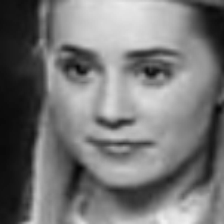

In [8]:
to_pil = torchvision.transforms.ToPILImage()
to_pil(dataset[0][0])

In [9]:
def cos_similarity(v1, v2):
    val = np.inner(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return val.reshape(-1)[0]

def euc_similarity(v1, v2):
    return np.linalg.norm(v1-v2)

In [10]:
def validate(model_f, cnt=20):
    model = torch.load(model_f, map_location=torch.device('cpu'))
    _, axs = plt.subplots(nrows=cnt, ncols=3, figsize=(3*4, cnt*4))
    for i in range(cnt):
        idx = random.randint(0, len(dataset)-1)
        img1, img2, img3 = dataset[idx]
        v1 = model(img1.reshape(1, 1, 224, 224)).detach().numpy()
        v2 = model(img2.reshape(1, 1, 224, 224)).detach().numpy()
        v3 = model(img3.reshape(1, 1, 224, 224)).detach().numpy()
        title = '%d %f %f %f %f %f %f' % (idx,
            euc_similarity(v1, v2), euc_similarity(v1, v3),
            cos_similarity(v1, v2), cos_similarity(v1, v3),
            np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())
        plt.sca(axs[i, 0])
        plt.imshow(img1.reshape(224, 224), cmap='gray')
        plt.axis('off')
        plt.sca(axs[i, 1])
        plt.imshow(img2.reshape(224, 224), cmap='gray')
        plt.axis('off')
        plt.title(title)
        plt.sca(axs[i, 2])
        plt.imshow(img3.reshape(224, 224), cmap='gray')
        plt.axis('off')
        print(title)

132 1.316754 6.393923 0.988485 0.556084 -5.432534 3.705198
293 1.069642 6.176875 0.988387 0.623433 -5.091523 3.978987
522 6.547543 7.618787 0.647398 0.455829 -4.003207 4.753693
164 3.397745 8.881310 0.801660 0.214619 -4.260665 5.832564
414 3.289270 7.477225 0.862963 0.358901 -4.745527 4.114427
130 1.774891 7.297309 0.984028 0.684662 -8.355577 2.984990
100 3.618566 8.321471 0.905978 0.206616 -4.383265 4.095627
201 3.451335 6.544436 0.910544 0.732788 -7.638675 4.266224
48 4.134622 9.493562 0.921316 0.227574 -8.373853 3.550479
99 3.380911 13.223311 0.917642 -0.334980 -6.673664 4.975035
594 4.334959 7.553514 0.745750 0.594353 -5.600568 5.325406
196 1.461500 8.640554 0.996131 0.712901 -9.707437 4.283643
733 2.384690 14.937009 0.980141 -0.560087 -9.407887 5.693339
116 3.582035 6.133426 0.889561 0.599630 -5.854053 4.340279
153 2.773324 4.888763 0.969955 0.915403 -9.090891 5.840510
198 1.197494 2.309810 0.984672 0.949566 -2.383682 5.976528
101 2.674404 12.934538 0.929246 -0.044700 -8.159168 3.

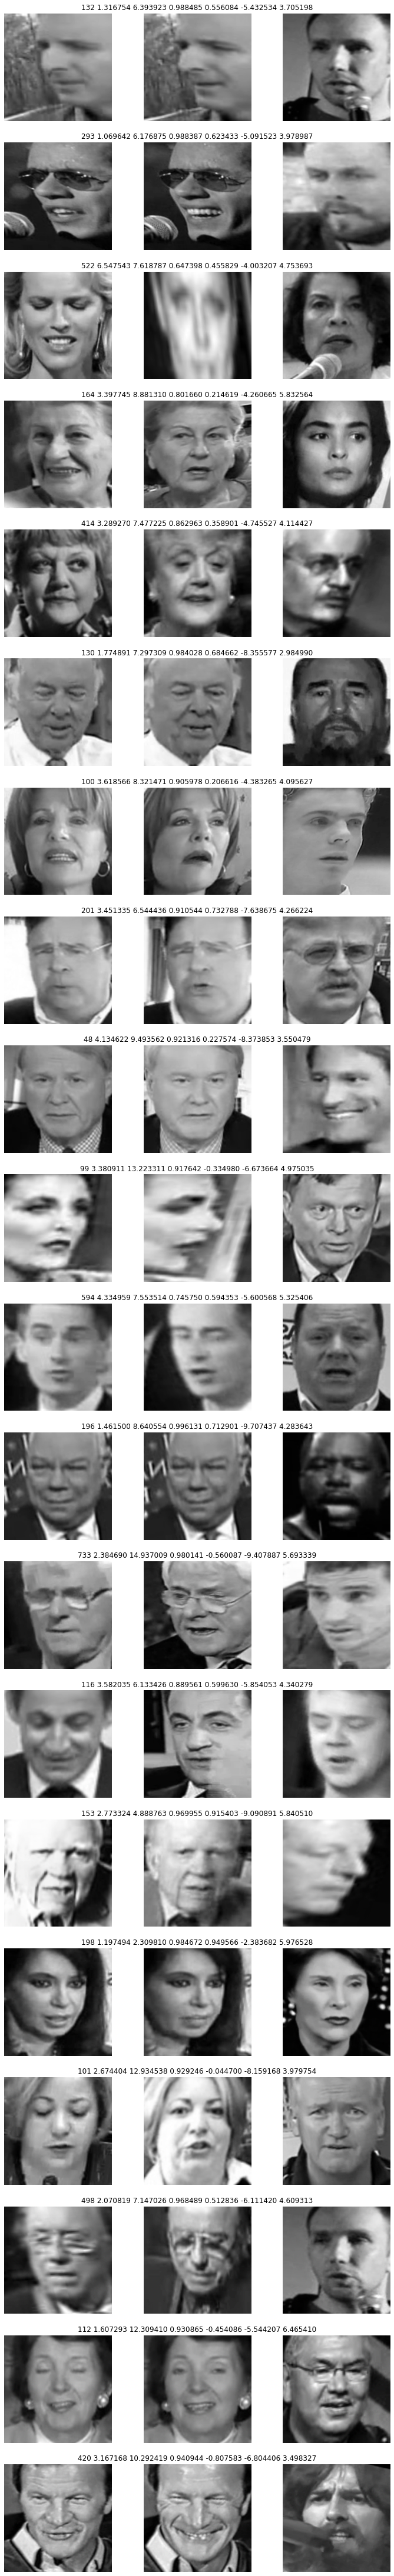

In [11]:
validate('faceid-model-ov8-0.02309628876459473.pt')

47 3.971184 7.293261 0.804560 0.380937 -4.430878 3.476206
710 0.732894 3.251220 0.997460 0.962483 -8.355658 4.736719
536 1.417593 5.298172 0.982387 0.771729 -6.192379 4.306882
212 0.787965 16.855783 0.993557 -0.370076 -9.365679 4.703738
700 2.240771 15.788049 0.967963 -0.334595 -7.285164 6.898915
497 1.500446 7.703553 0.873876 -0.132379 -3.305440 3.627924
55 2.402553 3.979273 0.959239 0.864911 -3.475378 5.271195
261 1.482551 10.958076 0.991899 0.248286 -9.128859 4.828748
136 2.849532 9.504245 0.968320 0.156941 -5.662302 5.465019
546 0.921898 4.811414 0.995251 0.900224 -8.205413 4.436583
655 1.668662 20.174322 0.993636 -0.546325 -9.131818 6.526935
162 1.070312 15.283464 0.994670 -0.284272 -5.163380 5.929184
779 2.535233 12.824817 0.963599 -0.347762 -6.165508 4.686648
281 3.079376 15.027605 0.932783 -0.337983 -5.474173 6.956023
642 2.886762 4.762110 0.914042 0.749305 -3.208123 4.294124
300 2.962118 4.142701 0.977864 0.889753 -3.952785 5.794166
273 1.831875 7.295218 0.967483 0.181548 -3.6

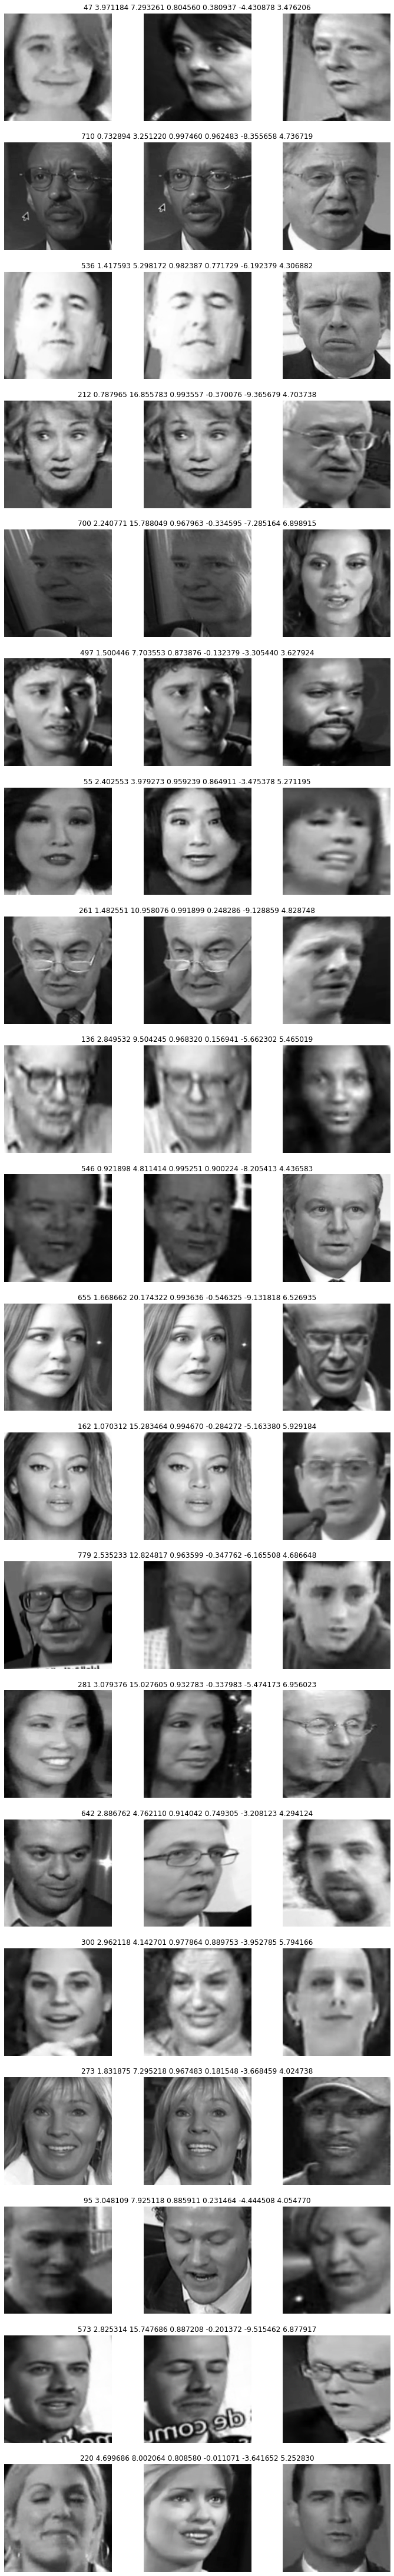

In [12]:
validate('faceid-model-ov8-0.016422454035053595.pt')